In [1]:
#@title Install dependencies
from IPython.display import clear_output, display, Image
!pip install timm transformers fairscale pycocoevalcap opencv-python ultralytics wordcloud

clear_output()

### Imports

In [2]:
import os
import subprocess
import pandas as pd
import re
import cv2
from ultralytics import YOLO

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import plotly.graph_objects as go
import networkx as nx

clear_output()

In [3]:
#@title Clone the repository
!git clone https://github.com/xinyu1205/recognize-anything.git

%cd recognize-anything
!git checkout ec6b4241c5036e337a4543838deb9bff4990de97

clear_output()

In [4]:
def download_checkpoints():
    if not os.path.exists('pretrained'):
        os.makedirs('pretrained')

    ram_weights_path = 'pretrained/ram_swin_large_14m.pth'
    if not os.path.exists(ram_weights_path):
        !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth -O pretrained/ram_swin_large_14m.pth
    else:
        print("RAM weights already downloaded!")

    tag2text_weights_path = 'pretrained/tag2text_swin_14m.pth'
    if not os.path.exists(tag2text_weights_path):
        !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/tag2text_swin_14m.pth -O pretrained/tag2text_swin_14m.pth
    else:
        print("Tag2Text weights already downloaded!")

In [5]:
download_checkpoints()
print('weights are downloaded!')

--2024-04-06 22:42:36--  https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.88, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth [following]
--2024-04-06 22:42:36--  https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/e6/78/e678f8565485a3f321b1180e4c7e1e18a89a9295028358eedffb98981b37e11a/15c729c793af28b9d107c69f85836a1356d76ea830d4714699fb62e55fcc08ed?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27ram_swin_large_14m.pth%3B+filename%3D%22ram_swin_large_14m.pth%22%3B&

### Video to Frames

In [5]:
import cv2
import os

video_path = "/content/left_half.mp4"

output_dir = os.path.join("/content", "extracted_frames")
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
  print("Error opening video!")
  exit()

fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_count = 1
actual_count = 0

while True:
  ret, frame = cap.read()

  if not ret:
    print("Can't receive frame (stream end?). Exiting...")
    break

  # Save frame as numbered image
  if frame_count % fps == 0:
    image_path = os.path.join(output_dir, f"{frame_count}.jpg")
    cv2.imwrite(image_path, frame)
    actual_count += 1

  frame_count += 1

  if frame_count > total_frames:
    break

cap.release()

print(f"Extracted {actual_count} frames to {output_dir}")

Extracted 308 frames to /content/extracted_frames


### Inference using Tag2Text

In [7]:
images_dir = "/content/extracted_frames"  # Update with your actual image directory

# Run inference for multiple images using RAM
output = subprocess.check_output([
    "python", "batch_inference.py",
    "--image-dir", images_dir,
    "--pretrained", "pretrained/tag2text_swin_14m.pth",
    "--model-type", "tag2text"
])

decoded_output = output.decode("utf-8")
image_caption = re.findall(r"\'filepath\': \'/content/extracted_frames/(.*?\.jpg)\',.*?\'image_caption\': \'(.*?)\'", decoded_output)

df_Tag2Text = pd.DataFrame(image_caption, columns=['Image', 'Tag2Text_Caption'])
df_Tag2Text.to_csv('/content/Captions_Tag2Text.csv')

### Inference using RAM

In [7]:
images_dir = "/content/extracted_frames_3"  # Update with your actual image directory

# Run inference for multiple images using RAM
output = subprocess.check_output([
    "python", "batch_inference.py",
    "--image-dir", images_dir,
    "--pretrained", "pretrained/ram_swin_large_14m.pth",
    "--model-type", "ram"
])

decoded_output = output.decode("utf-8")
image_tags = re.findall(r"'filepath': '.*/extracted_frames_3/(.*?\.jpg)', 'model_identified_tags': '(.*?)'", decoded_output)

df_RAM = pd.DataFrame(image_tags, columns=['Image', 'RAM_Tags'])
df_RAM.to_csv('/content/Tags_RAM.csv')

### Inference using YOLO

In [8]:
model = YOLO('yolov8n.pt')
source = '/content/extracted_frames_3'
results = model(source, stream=False, save=True, save_txt=True, project="/content/YOLO_inference")

100%|██████████| 6.23M/6.23M [00:00<00:00, 128MB/s]




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1833 /content/extracted_frames_3/10010.jpg: 480x640 (no detections), 82.2ms
image 2/1833 /content/extracted_frames_3/10024.jpg: 480x640 (no detections), 7.8ms
image 3/1833 /content/extracted_frames_3/10038.jpg: 480x640 2 persons, 2 cars, 6.8ms
image 4/1833 /content/extracted_frames_3/10052.jpg: 480x640 3 persons, 1 car, 9.4ms
image 5/1833 /content/extracted_frames_3/10066.jpg: 480x640 2 persons, 1 car, 9.5ms
image 6/1833 /content/extracted_fram

In [9]:
# Dictionary of class labels
class_labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck',
                8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
                14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear',
                22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase',
                29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat',
                35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle',
                40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana',
                47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog',
                53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
                60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote',
                66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink',
                72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
                78: 'hair drier', 79: 'toothbrush'}

# Path to the labels folder
labels_folder = "/content/YOLO_inference/predict/labels"

def parse_label_file(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        class_counts = {class_label: 0 for class_label in class_labels.values()}
        for line in lines:
            class_index = int(line.split()[0])
            class_name = class_labels[class_index]
            class_counts[class_name] += 1
    return class_counts

data = []
for label_file in os.listdir(labels_folder):
    if label_file.endswith('.txt'):
        image_name = os.path.splitext(label_file)[0] + '.jpg'
        label_file_path = os.path.join(labels_folder, label_file)
        class_counts = parse_label_file(label_file_path)
        class_counts['Image'] = image_name
        data.append(class_counts)

df_YOLO = pd.DataFrame(data).fillna(0)
df_YOLO = df_YOLO[['Image'] + list(class_labels.values())]

In [10]:
df_YOLO_non_null = df_YOLO.loc[:, (df_YOLO != 0).any(axis=0)]
df_YOLO_non_null['Image_Num'] = df_YOLO_non_null['Image'].str.replace('.jpg', '').astype(int)
df_YOLO_non_null = df_YOLO_non_null.sort_values(by='Image_Num')
df_YOLO_non_null.drop('Image_Num', axis=1, inplace=True)
df_YOLO_non_null.reset_index(inplace=True)
df_YOLO_non_null.drop('index', axis=1, inplace=True)
df_YOLO_non_null.to_csv('/content/Yolo_counts.csv')

<ipython-input-10-eef123892109>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_YOLO_non_null['Image_Num'] = df_YOLO_non_null['Image'].str.replace('.jpg', '').astype(int)
<ipython-input-10-eef123892109>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_YOLO_non_null['Image_Num'] = df_YOLO_non_null['Image'].str.replace('.jpg', '').astype(int)


In [11]:
# Function to create the tags string
def create_tags_string(row):
    tags_list = []
    for col in df_YOLO.columns[1:]:
        if row[col] > 0:
            tags_list.append(f"{int(row[col])} {col}")
    return ', '.join(tags_list)

df_YOLO['YOLO_Tags'] = df_YOLO.apply(create_tags_string, axis=1)
df_YOLO_tags = df_YOLO[['Image', 'YOLO_Tags']]
df_YOLO_tags.to_csv('/content/Yolo_tags.csv')

### Merge RAM and YOLO

In [12]:
df_final = pd.merge(df_RAM, df_YOLO_tags, on='Image', how='inner')
df_final['Image_Num'] = df_final['Image'].str.replace('.jpg', '').astype(int)
df_final = df_final.sort_values(by='Image_Num')
df_final.drop('Image_Num', axis=1, inplace=True)
df_final.reset_index(inplace=True)
df_final.drop('index', axis=1, inplace=True)
df_final.to_csv('/content/YOLO+RAM.csv')

<ipython-input-12-6097d8033e52>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_final['Image_Num'] = df_final['Image'].str.replace('.jpg', '').astype(int)


In [13]:
df_final

,Image,RAM_Tags,YOLO_Tags
0,84.jpg,building | car | city | city street | crosswal...,"11 car, 1 truck"
1,98.jpg,car | city | city street | cross | crosswalk |...,"6 car, 1 truck"
2,112.jpg,car | city | city street | crosswalk | interse...,"7 car, 1 truck"
3,126.jpg,car | city | city street | cross | crosswalk |...,"9 car, 1 truck"
4,140.jpg,car | city | city street | cross | crosswalk |...,"1 person, 7 car, 1 truck"
...,...,...,...
1405,25242.jpg,car | city | city street | cross | crosswalk |...,"5 car, 1 surfboard"
1406,25256.jpg,building | car | city | city street | cross | ...,4 car
1407,25270.jpg,car | city | city street | crosswalk | interse...,6 car
1408,25284.jpg,car | city | city street | crosswalk | interse...,6 car


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Deciphering RAM Tags

### Wordcloud

In [13]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [76]:
df = pd.read_csv('YOLO+RAM_chase1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

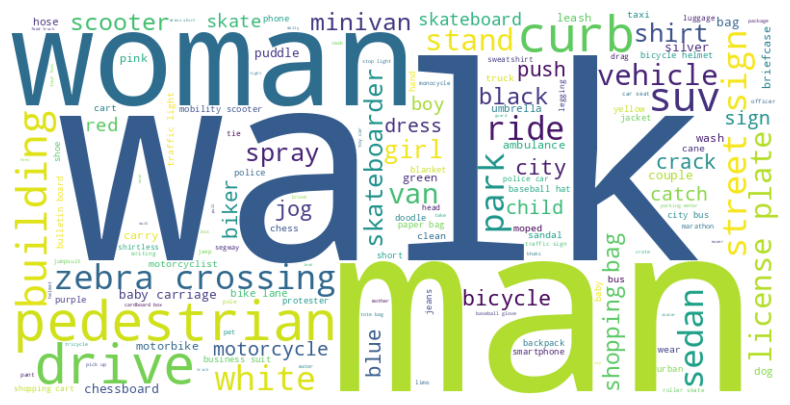

In [77]:
text = ' | '.join(df['RAM_Tags'])
words = text.split('|')
words = [word.strip().lower() for word in words]

# Count the occurrences of each word
word_counts = pd.Series(words).value_counts()

#Make a df for storage
word_counts_df = pd.DataFrame(word_counts)
word_counts_df.reset_index(inplace=True)
word_counts_df.columns = ['Tag','RAM_Count']

#Exclude words that occur too-frequently as they are common image characteristics like road, city_street etc.
threshold = 0.75 * len(df)
word_counts_filtered = word_counts[word_counts <= threshold]

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Making a filtered tag list that does not include tags that occur a lot or too little

In [78]:
word_counts_df_filtered = word_counts_df[~((word_counts_df['RAM_Count']>0.75*len(df)) | (word_counts_df['RAM_Count'] <= 4))]

In [89]:
word_counts_df_filtered

,Tag,RAM_Count
9,walk,1986
10,man,1535
11,woman,834
12,pedestrian,823
13,drive,820
...,...,...
122,roller skate,5
123,pant,5
124,writing,5
125,jumpsuit,5


### Co-occurence Matrix

In [79]:
all_tags = set()
for tags in df['RAM_Tags']:
    all_tags.update(tags.split(' | '))
all_tags = sorted(list(all_tags))

# Creating co-occurrence matrices
co_occurrence_overall = pd.DataFrame(index=all_tags, columns=all_tags).fillna(0)

# Function to update co-occurrence matrices
def update_co_occurrence(df, co_occurrence_matrix):
    for _, row in df.iterrows():
        tags = row['RAM_Tags'].split(' | ')
        for i in range(len(tags)):
            for j in range(i+1, len(tags)):
                co_occurrence_matrix.at[tags[i], tags[j]] += 1
                co_occurrence_matrix.at[tags[j], tags[i]] += 1

# Updating co-occurrence matrices
update_co_occurrence(df, co_occurrence_overall) #This makes the co-occurence matrix

Visualising the co-occurence matrix as a heatmap

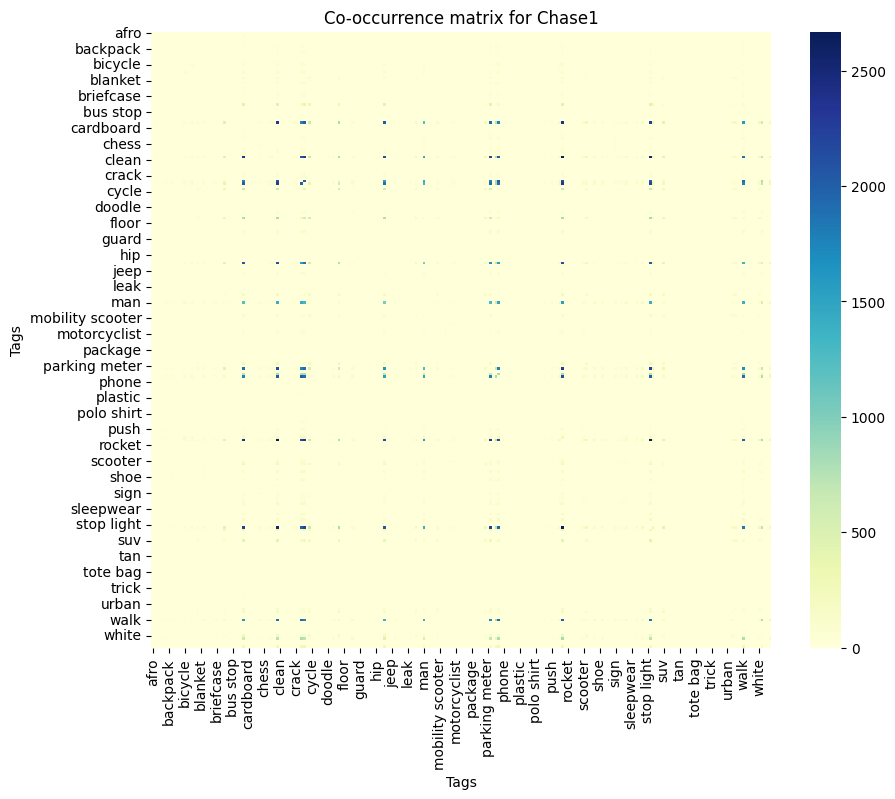

In [80]:
def plot_co_occurrence_matrix(co_occurrence_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(co_occurrence_matrix, cmap="YlGnBu", annot=False, fmt='g')
    plt.title(title)
    plt.xlabel('Tags')
    plt.ylabel('Tags')
    plt.show()

plot_co_occurrence_matrix(co_occurrence_overall, "Co-occurrence matrix for Chase1")

Visualising the co-occurence matrix as a network graph

In [91]:
# Function to create a graph from the co-occurrence matrix
def create_graph_from_co_occurrence(co_occurrence_matrix, word_counts_df):
    G = nx.Graph()
    filtered_tags = set(word_counts_df['Tag'])  # Get only the tags present in word_counts_df_filtered
    for i in range(len(co_occurrence_matrix.index)):
        tag1 = co_occurrence_matrix.index[i]
        if tag1 in filtered_tags:
            G.add_node(tag1)
            for j in range(i + 1, len(co_occurrence_matrix.columns)):
                tag2 = co_occurrence_matrix.columns[j]
                if tag2 in filtered_tags:
                    weight = co_occurrence_matrix.iloc[i, j]
                    if weight >= 3:  # Only add edge if co-occurrence count is 3 or more
                        G.add_edge(tag1, tag2, weight=weight)
    # Assigning node size based on word counts
    for node in G.nodes():
        word_count = word_counts_df[word_counts_df['Tag'] == node]['RAM_Count'].values
        if len(word_count) > 0:
            G.nodes[node]['size'] = word_count[0]  # Taking the word count from word_counts_df
    return G

# Creating a Plotly figure
def plot_network(graph, title):
    pos = nx.spring_layout(graph, seed=42)  # Layout for better visualization

    max_weight = max([graph.edges[edge]['weight'] for edge in graph.edges()]) if graph.edges() else 1

    edge_trace = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = graph.edges[edge]['weight']
        edge_trace.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None], mode='lines', line=dict(width=0.04 * weight, color=f'rgb({int(128 * weight / max_weight)}, {int(128 * weight / max_weight)}, {int(128 * weight / max_weight)})')))  # Adjusting edge width and color

    node_trace = go.Scatter(x=[], y=[], mode='markers', text=[], marker=dict(size=[], color=[], colorscale='Viridis', opacity=0.7))
    for node in graph.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['marker']['size'] += (graph.nodes[node].get('size', 1) * 0.04,)  # Adjusting node size
        connected_nodes = list(graph.neighbors(node))
        top_connected_nodes = sorted(connected_nodes, key=lambda x: graph.edges[(node, x)]['weight'], reverse=True)[:20]  # Get top 20 most connected nodes
        top_connected_nodes_text = "<br>".join(top_connected_nodes) if top_connected_nodes else "None"
        #node_trace['text'] += (node,)
        node_trace['text'] += ([f'Node: {node}<br>Connections: {len(connected_nodes)}<br>Top Connected Nodes: {top_connected_nodes_text}'],)  # Adjusting node text
        node_trace['marker']['color'] += (graph.nodes[node].get('size', 1) * 10,)  # Adjusting node color

    fig = go.Figure(data=[*edge_trace, node_trace],
                    layout=go.Layout(title=title, showlegend=False, hovermode='closest',
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

# Creating graphs from co-occurrence matrices
graph_overall = create_graph_from_co_occurrence(co_occurrence_overall, word_counts_df_filtered)

# Plotting networks
plot_network(graph_overall, "Network for Chase1")

In [82]:
total_nodes = graph_overall.number_of_nodes()
print("Total number of nodes in the graph:", total_nodes)

Total number of nodes in the graph: 118


### Man v/s Woman Distribution

In [35]:
df['man'] = df['RAM_Tags'].str.contains(r'\bman\b|\bboy\b', case=False, regex=True).astype(int)
df['woman'] = df['RAM_Tags'].str.contains(r'\bwoman\b|\bgirl\b', case=False, regex=True).astype(int)

### Additional Work

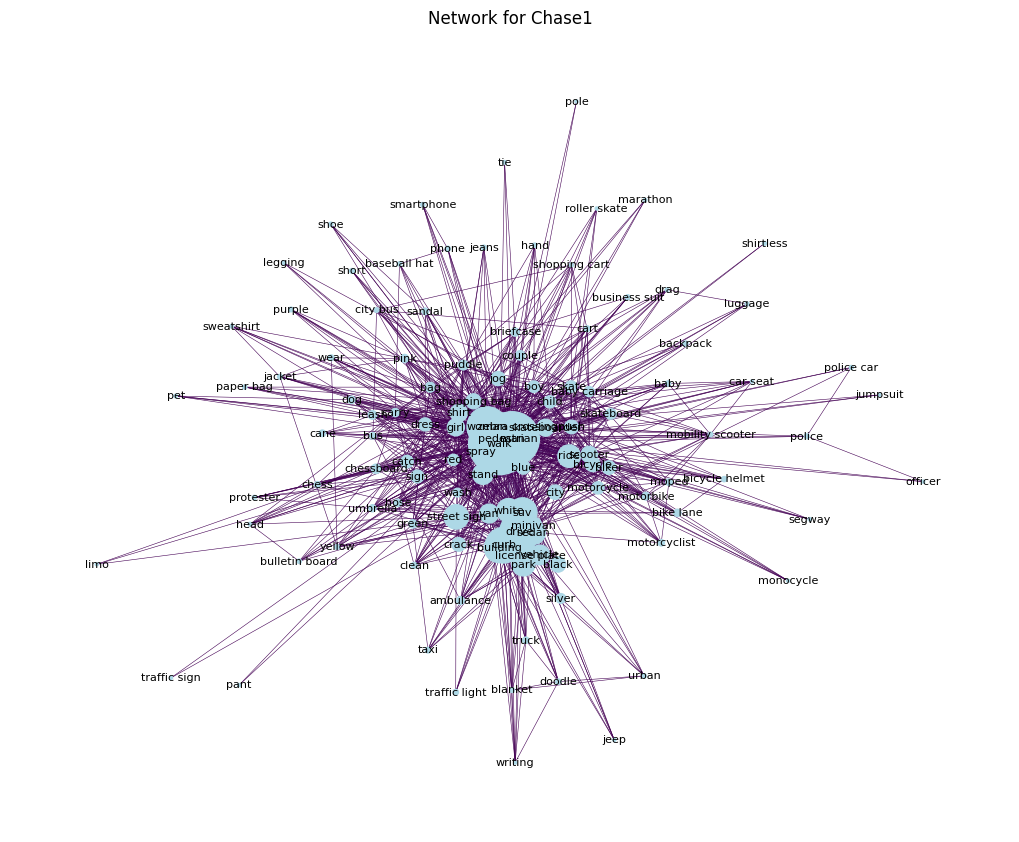

In [63]:
import networkx as nx

# Function to create a graph from the co-occurrence matrix
def create_graph_from_co_occurrence(co_occurrence_matrix, word_counts_df):
    G = nx.Graph()
    filtered_tags = set(word_counts_df['Tag'])  # Get only the tags present in word_counts_df_filtered
    for i in range(len(co_occurrence_matrix.index)):
        tag1 = co_occurrence_matrix.index[i]
        if tag1 in filtered_tags:
            G.add_node(tag1)
            for j in range(i + 1, len(co_occurrence_matrix.columns)):
                tag2 = co_occurrence_matrix.columns[j]
                if tag2 in filtered_tags:
                    weight = co_occurrence_matrix.iloc[i, j]
                    if weight >= 3:  # Only add edge if co-occurrence count is 3 or more
                        G.add_edge(tag1, tag2, weight=weight)
    # Assigning node size based on word counts
    for node in G.nodes():
        word_count = word_counts_df[word_counts_df['Tag'] == node]['RAM_Count'].values
        if len(word_count) > 0:
            G.nodes[node]['size'] = word_count[0]  # Taking the word count from word_counts_df
    return G

# Plotting function for the network
def plot_network(graph, title):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=4)  # Layout for better visualization
    sizes = [graph.nodes[node].get('size', 1) * 1 for node in graph.nodes()]
    max_weight = max([graph.edges[edge]['weight'] for edge in graph.edges()])  # Max co-occurrence count for scaling color
    edge_colors = [int(128 * graph.edges[edge]['weight'] / max_weight) for edge in graph.edges()]  # Adjusting edge color
    nx.draw(graph, pos, with_labels=True, node_size=sizes, font_size=8, node_color='lightblue', edge_color=edge_colors, width=0.4, cmap=plt.cm.gray)
    plt.title(title)
    plt.show()

# Creating graphs from co-occurrence matrices
graph_overall = create_graph_from_co_occurrence(co_occurrence_overall, word_counts_df_filtered)
# Plotting networks
plot_network(graph_overall, "Network for Chase1")

The average person takes about 7-10 seconds to cross the road, which means they would be continously detected for 7-10 frames. However since objects are of different sizes some stay for the same frame lenght while some only appear in a couple of frames.

This is useful information to determine a threshold for the co-occurence matrix. For simplification reasons, we determine the threshold to be 4.